In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, cv2, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

!pip install np_utils

from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout

from sklearn.utils import shuffle

!pip install sklearn
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
TRAIN_DIR = '/content/drive/My Drive/cat/train'
TEST_DIR = '/content/drive/My Drive/cat/test'
ROWS = 64
COLS = 64
CHANNELS = 3

In [4]:
train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [5]:
len(train_images)

502

In [6]:
len(test_images)

100

In [7]:
import tensorflow as tf
import glob
import random #0.00002

In [67]:
# initial parameters
epochs = 50
lr = 0.00002
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

# load image files from the dataset
dir = "/content/drive/My Drive/cat/train"

image_files = [f for f in glob.glob(dir + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.asarray(image)
    data.append(image)

    label = img.split("/content/drive/My Drive/cat/train") 
    if label == "dog":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

In [68]:
# split dataset for training and validation
(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

In [69]:
data, labels = shuffle(data, labels)

In [70]:
classes = {0: 'cats',
           1: 'dogs'}

In [71]:
y_train = to_categorical(y_train, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
y_val = to_categorical(y_val, num_classes=2)

In [72]:
X_train = np.array(X_train, dtype='float') / 255.0
X_val = np.array(X_val, dtype='float') / 255.0

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [74]:
# augmenting datset 
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [75]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [76]:
# define model1
def build(width, height, depth, classes):
    model1 = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1
    
    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first", 
    # set axis=1 in BatchNormalization.

    model1.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization(axis=1))
    model1.add(MaxPooling2D(pool_size=(3,3)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(64, (3,3), padding="same"))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization(axis=1))

    model1.add(Conv2D(64, (3,3), padding="same"))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization(axis=1))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    model1.add(Dropout(0.25))

    model1.add(Conv2D(128, (3,3), padding="same"))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization(axis=1))

    model1.add(Conv2D(128, (3,3), padding="same"))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization(axis=1))
    model1.add(MaxPooling2D(pool_size=(2,2)))
    model1.add(Dropout(0.25))

    model1.add(Flatten())
    model1.add(Dense(1024))
    model1.add(Activation("relu"))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.5))

    model1.add(Dense(classes))
    model1.add(Activation("sigmoid"))

    return model1

# build model
model1 = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2],
                            classes=2)
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model1.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the model
model1.fit_generator(aug.flow(X_train, y_train, batch_size=batch_size),
                        validation_data=(X_val,y_val),
                        steps_per_epoch=len(X_train) // batch_size,
                        epochs=epochs, verbose=1)

Epoch 1/50
6/6 [==============================] - 1s 192ms/step - loss: 1.1025 - accuracy: 0.4451 - val_loss: 0.7012 - val_accuracy: 0.0693
Epoch 2/50
6/6 [==============================] - 1s 116ms/step - loss: 1.0638 - accuracy: 0.5045 - val_loss: 0.6971 - val_accuracy: 0.2574
Epoch 3/50
6/6 [==============================] - 1s 131ms/step - loss: 1.0592 - accuracy: 0.5045 - val_loss: 0.6673 - val_accuracy: 1.0000
Epoch 4/50
6/6 [==============================] - 1s 134ms/step - loss: 1.0697 - accuracy: 0.5234 - val_loss: 0.6389 - val_accuracy: 1.0000
Epoch 5/50
6/6 [==============================] - 1s 116ms/step - loss: 1.0191 - accuracy: 0.4955 - val_loss: 0.6199 - val_accuracy: 1.0000
Epoch 6/50
6/6 [==============================] - 1s 114ms/step - loss: 1.0688 - accuracy: 0.4955 - val_loss: 0.6153 - val_accuracy: 1.0000
Epoch 7/50
6/6 [==============================] - 1s 114ms/step - loss: 0.9985 - accuracy: 0.5045 - val_loss: 0.6117 - val_accuracy: 1.0000
Epoch 8/50
6/6 [====

In [77]:
# step-1: read the data
img = cv2.imread('/content/drive/My Drive/cat/test/8.jpg') # BGR

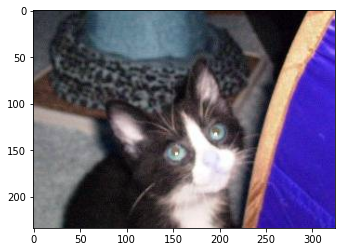

In [78]:
plt.imshow(img)

In [79]:
img = cv2.resize(img,(img_dims[0],img_dims[1]))
img= img.astype('float')/ 255.0
img = tf.keras.preprocessing.image.array_to_img(img)
img=np.expand_dims(img,axis=0)
img.shape

(1, 96, 96, 3)

In [80]:
results = model1.predict(img)

In [81]:
results

array([[1., 0.]], dtype=float32)

In [82]:
import pandas as pd

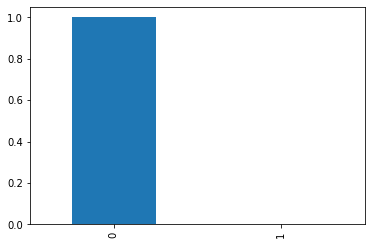

In [83]:
pd.Series(results.flatten()).plot(kind='bar')      

In [84]:
img2 = cv2.imread('/content/drive/My Drive/cat/test/42.jpg') # BGR

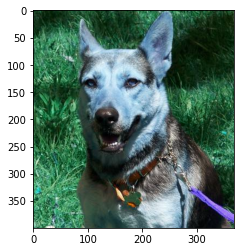

In [85]:
plt.imshow(img2)

In [86]:
img2 = cv2.resize(img2,(img_dims[0],img_dims[1]))
img2= img2.astype('float')/ 255.0
img2 = tf.keras.preprocessing.image.array_to_img(img2)
img2=np.expand_dims(img2,axis=0)
img2.shape

(1, 96, 96, 3)

In [87]:
results2 = model1.predict(img2)

In [88]:
results2

array([[2.1445244e-35, 1.3420988e-06]], dtype=float32)

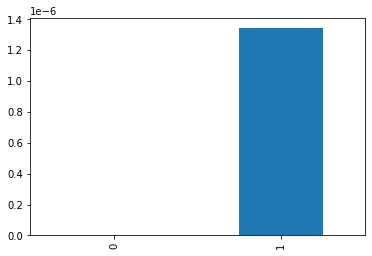

In [89]:
pd.Series(results2.flatten()).plot(kind='bar')      